
## Problem Statement

Train a machine learning regression model to predict rating of a software developer using the training data provided and implement a working prediction api

# 1.0 Importing the Libraries

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import norm, skew
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy.special import boxcox1p

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error


# 2 Extrapolatory Data Analysis

## 2.1 Shape of data 

In [2]:
data = pd.read_csv("pa_work_sample_training_data.csv")
print("Number of rows ",data.shape[0])
print("Number of columns ",data.shape[1])

Number of rows  330
Number of columns  42


## 2.2 Understanding data range

In [3]:
data.describe()

,tx_name,Task Name,total_correctness,total_compute,total_robustness,total_memtotal,score_percentage,Time spent,id_task_session,id_infra_instan,...,fanout_submit,ce_units_submit,aberrant_ce_units_submit,id_test_session,correctness_norm,compute_norm,robustness_norm,memtotal_norm,task_score,avg_bce
count,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.00000,330.000000,...,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000
mean,63.530303,7.151515,2.890909,0.042424,0.142424,0.024242,66.013030,0.779394,3306.39697,810882.675758,...,0.951515,11.561604,0.286182,3503.975758,15.653085,1.515152,1.094276,0.606061,6.882035,2.209050
std,33.552490,5.233869,3.655396,0.201861,0.557638,0.154035,6.647026,0.335008,494.61592,48640.652568,...,1.246544,5.961543,0.495819,1311.357228,25.355037,12.234093,6.119602,6.724900,14.988303,1.003051
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.400000,0.000000,1942.00000,644981.000000,...,0.000000,0.414213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.301481
25%,32.000000,2.000000,0.000000,0.000000,0.000000,0.000000,62.375000,0.708333,2878.25000,812433.000000,...,0.000000,6.836760,0.000000,2018.750000,0.000000,0.000000,0.000000,0.000000,0.000000,1.495856
50%,67.500000,7.000000,2.000000,0.000000,0.000000,0.000000,67.550000,0.950000,3504.50000,834096.500000,...,0.500000,10.050557,0.096708,4367.000000,4.000000,0.000000,0.000000,0.000000,0.510204,2.009800
75%,97.000000,12.000000,5.000000,0.000000,0.000000,0.000000,69.975000,1.000000,3679.75000,835470.000000,...,2.000000,14.605968,0.348084,4553.750000,18.750000,0.000000,0.000000,0.000000,4.000000,2.935249
max,116.000000,15.000000,14.000000,1.000000,3.000000,1.000000,82.000000,1.000000,3846.00000,837393.000000,...,6.000000,31.263434,4.255237,4749.000000,100.000000,100.000000,50.000000,100.000000,100.000000,4.118758


# A.1 Observations

1. From above table we get to know the max and min values of the various feature columns and get to know the data as a whole

## 2.3 Checking for Null/NaN values

In [4]:
data.isnull().any()

tx_name                      False
Task Name                    False
tx_difficulty                False
total_correctness            False
total_compute                False
total_robustness             False
total_memtotal               False
made_submission              False
compile_success              False
score_percentage             False
Time spent                   False
Remarks on Score             False
id_task_session              False
js_comments                  False
id_infra_instan              False
nu_pgmr_comment_flux_all     False
nu_pgmr_cyclo_flux_all       False
nu_pgmr_filesize_flux_all    False
nu_pgmr_nom_flux_all         False
nu_pgmr_dac_flux_all         False
nu_pgmr_fanout_flux_all      False
nu_loc_flux_source_all       False
nu_loc_added_source_all      False
nu_ce_models_units_all       False
nu_aberrant_ce_units_all     False
nu_ce_hours_all              False
nu_aberrant_ce_all           False
loc_submit                   False
cyclo_submit        

# A.2 Observation 

None of the data rows are empty which means we need not impute data values
else we would have proceeded with following data imputation techniques

1. SMOTE (KNN based data imputation)
2. Mode based data imputation(for categorical features)
3. Mean based data imputation(for continuous/numerical features)

Also 

Following features are of type object hence we need to convert it into numerical values by Label Encoding
1. Remarks on Score
2. compile_success
3. tx_file_type
4. tx_difficulty


## 2.4 Removing irrelevant features

This step involves dropping the columns which 
1. does not have any relation with independent variable (by intuition)
2. features which possess the single value in the dataset i.e has **zero variance**

In [5]:
data['made_submission'].value_counts()

True    330
Name: made_submission, dtype: int64

In [6]:
# dropping the columns which does not have any relation with independent variable (by intuition)
# or the single value columns from the dataset
data = data.drop(columns = ['js_comments','made_submission','id_task_session','id_test_session', 'id_infra_instan','Task Name','tx_name'])

# 2.5 Label Encoding Features

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tx_difficulty              330 non-null    object 
 1   total_correctness          330 non-null    int64  
 2   total_compute              330 non-null    int64  
 3   total_robustness           330 non-null    int64  
 4   total_memtotal             330 non-null    int64  
 5   compile_success            330 non-null    bool   
 6   score_percentage           330 non-null    float64
 7   Time spent                 330 non-null    float64
 8   Remarks on Score           330 non-null    object 
 9   nu_pgmr_comment_flux_all   330 non-null    int64  
 10  nu_pgmr_cyclo_flux_all     330 non-null    int64  
 11  nu_pgmr_filesize_flux_all  330 non-null    int64  
 12  nu_pgmr_nom_flux_all       330 non-null    int64  
 13  nu_pgmr_dac_flux_all       330 non-null    int64  

In [8]:
# code to label encode the object (character based ) features
lab_en1 = LabelEncoder()
lab_en2 = LabelEncoder()
lab_en3 = LabelEncoder()
lab_en4 = LabelEncoder()

data.loc[:,'Remarks on Score'] = lab_en1.fit_transform(data.loc[:,'Remarks on Score'])
data.loc[:,'compile_success'] = lab_en2.fit_transform(data.loc[:,'compile_success'])
data.loc[:,'tx_file_type'] = lab_en3.fit_transform(data.loc[:,'tx_file_type'])
data.loc[:,'tx_difficulty'] = lab_en4.fit_transform(data.loc[:,'tx_difficulty'])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tx_difficulty              330 non-null    int32  
 1   total_correctness          330 non-null    int64  
 2   total_compute              330 non-null    int64  
 3   total_robustness           330 non-null    int64  
 4   total_memtotal             330 non-null    int64  
 5   compile_success            330 non-null    int64  
 6   score_percentage           330 non-null    float64
 7   Time spent                 330 non-null    float64
 8   Remarks on Score           330 non-null    int32  
 9   nu_pgmr_comment_flux_all   330 non-null    int64  
 10  nu_pgmr_cyclo_flux_all     330 non-null    int64  
 11  nu_pgmr_filesize_flux_all  330 non-null    int64  
 12  nu_pgmr_nom_flux_all       330 non-null    int64  
 13  nu_pgmr_dac_flux_all       330 non-null    int64  

## 2.6 Understanding data distribution

I plot a **box plot** to understand the presence of outliers and distribution of the data samples across various features

From the plot it seems that outliers is not present in significant numbers and removal of more samples on basis of outliers will further shrink our small dataset.

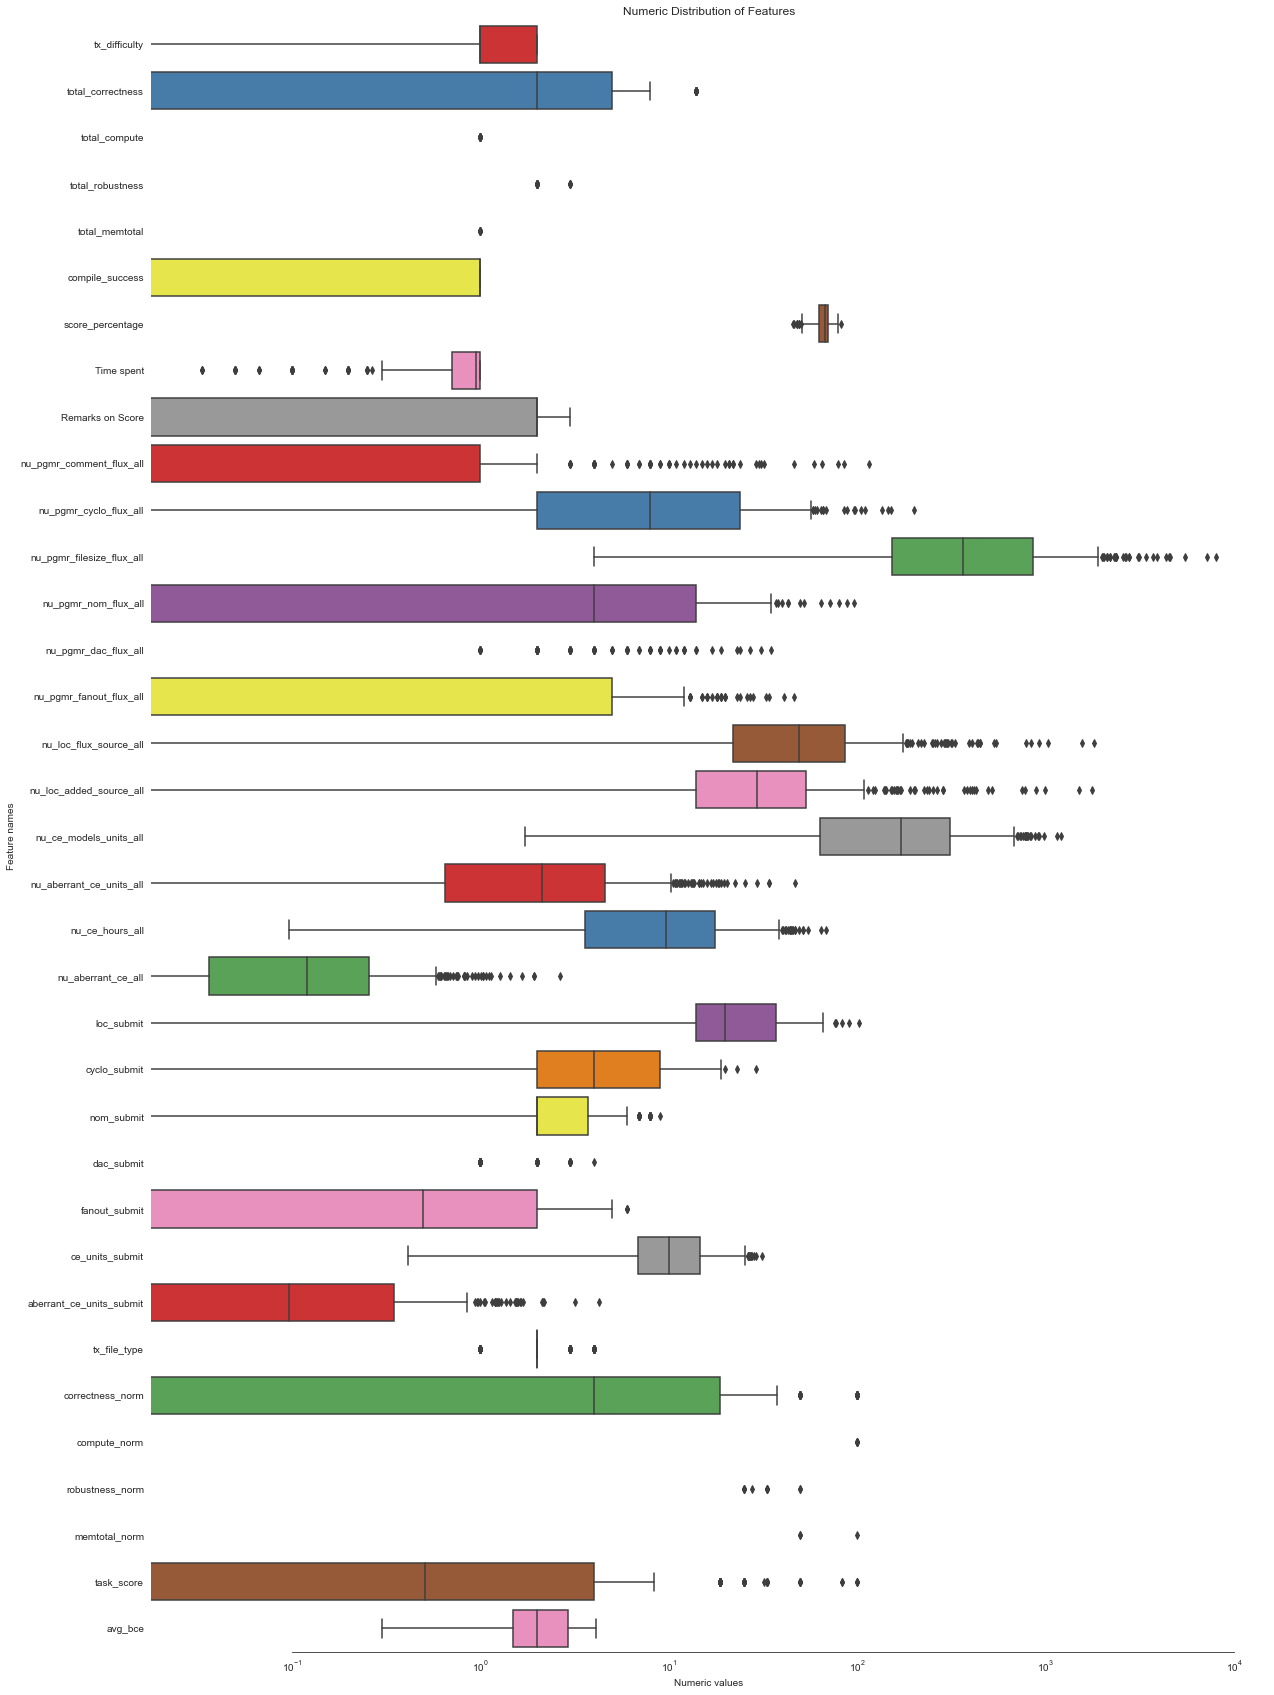

In [10]:
# code to prepare the box plot for all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in data.columns:
    if data[i].dtype in numeric_dtypes:
        numeric.append(i)
        
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(20, 30))
ax.set_xscale("log")
ax = sns.boxplot(data=data[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

# 2.7 Understanding Coorelations in Dataset

It involves following steps
1. finding out the coorelation between the two features in the dataset
2. Filtering the high coorelation based features so as to reduce dimensionality
3. Finding the features coorelated highly with target variable i.e avg_bce

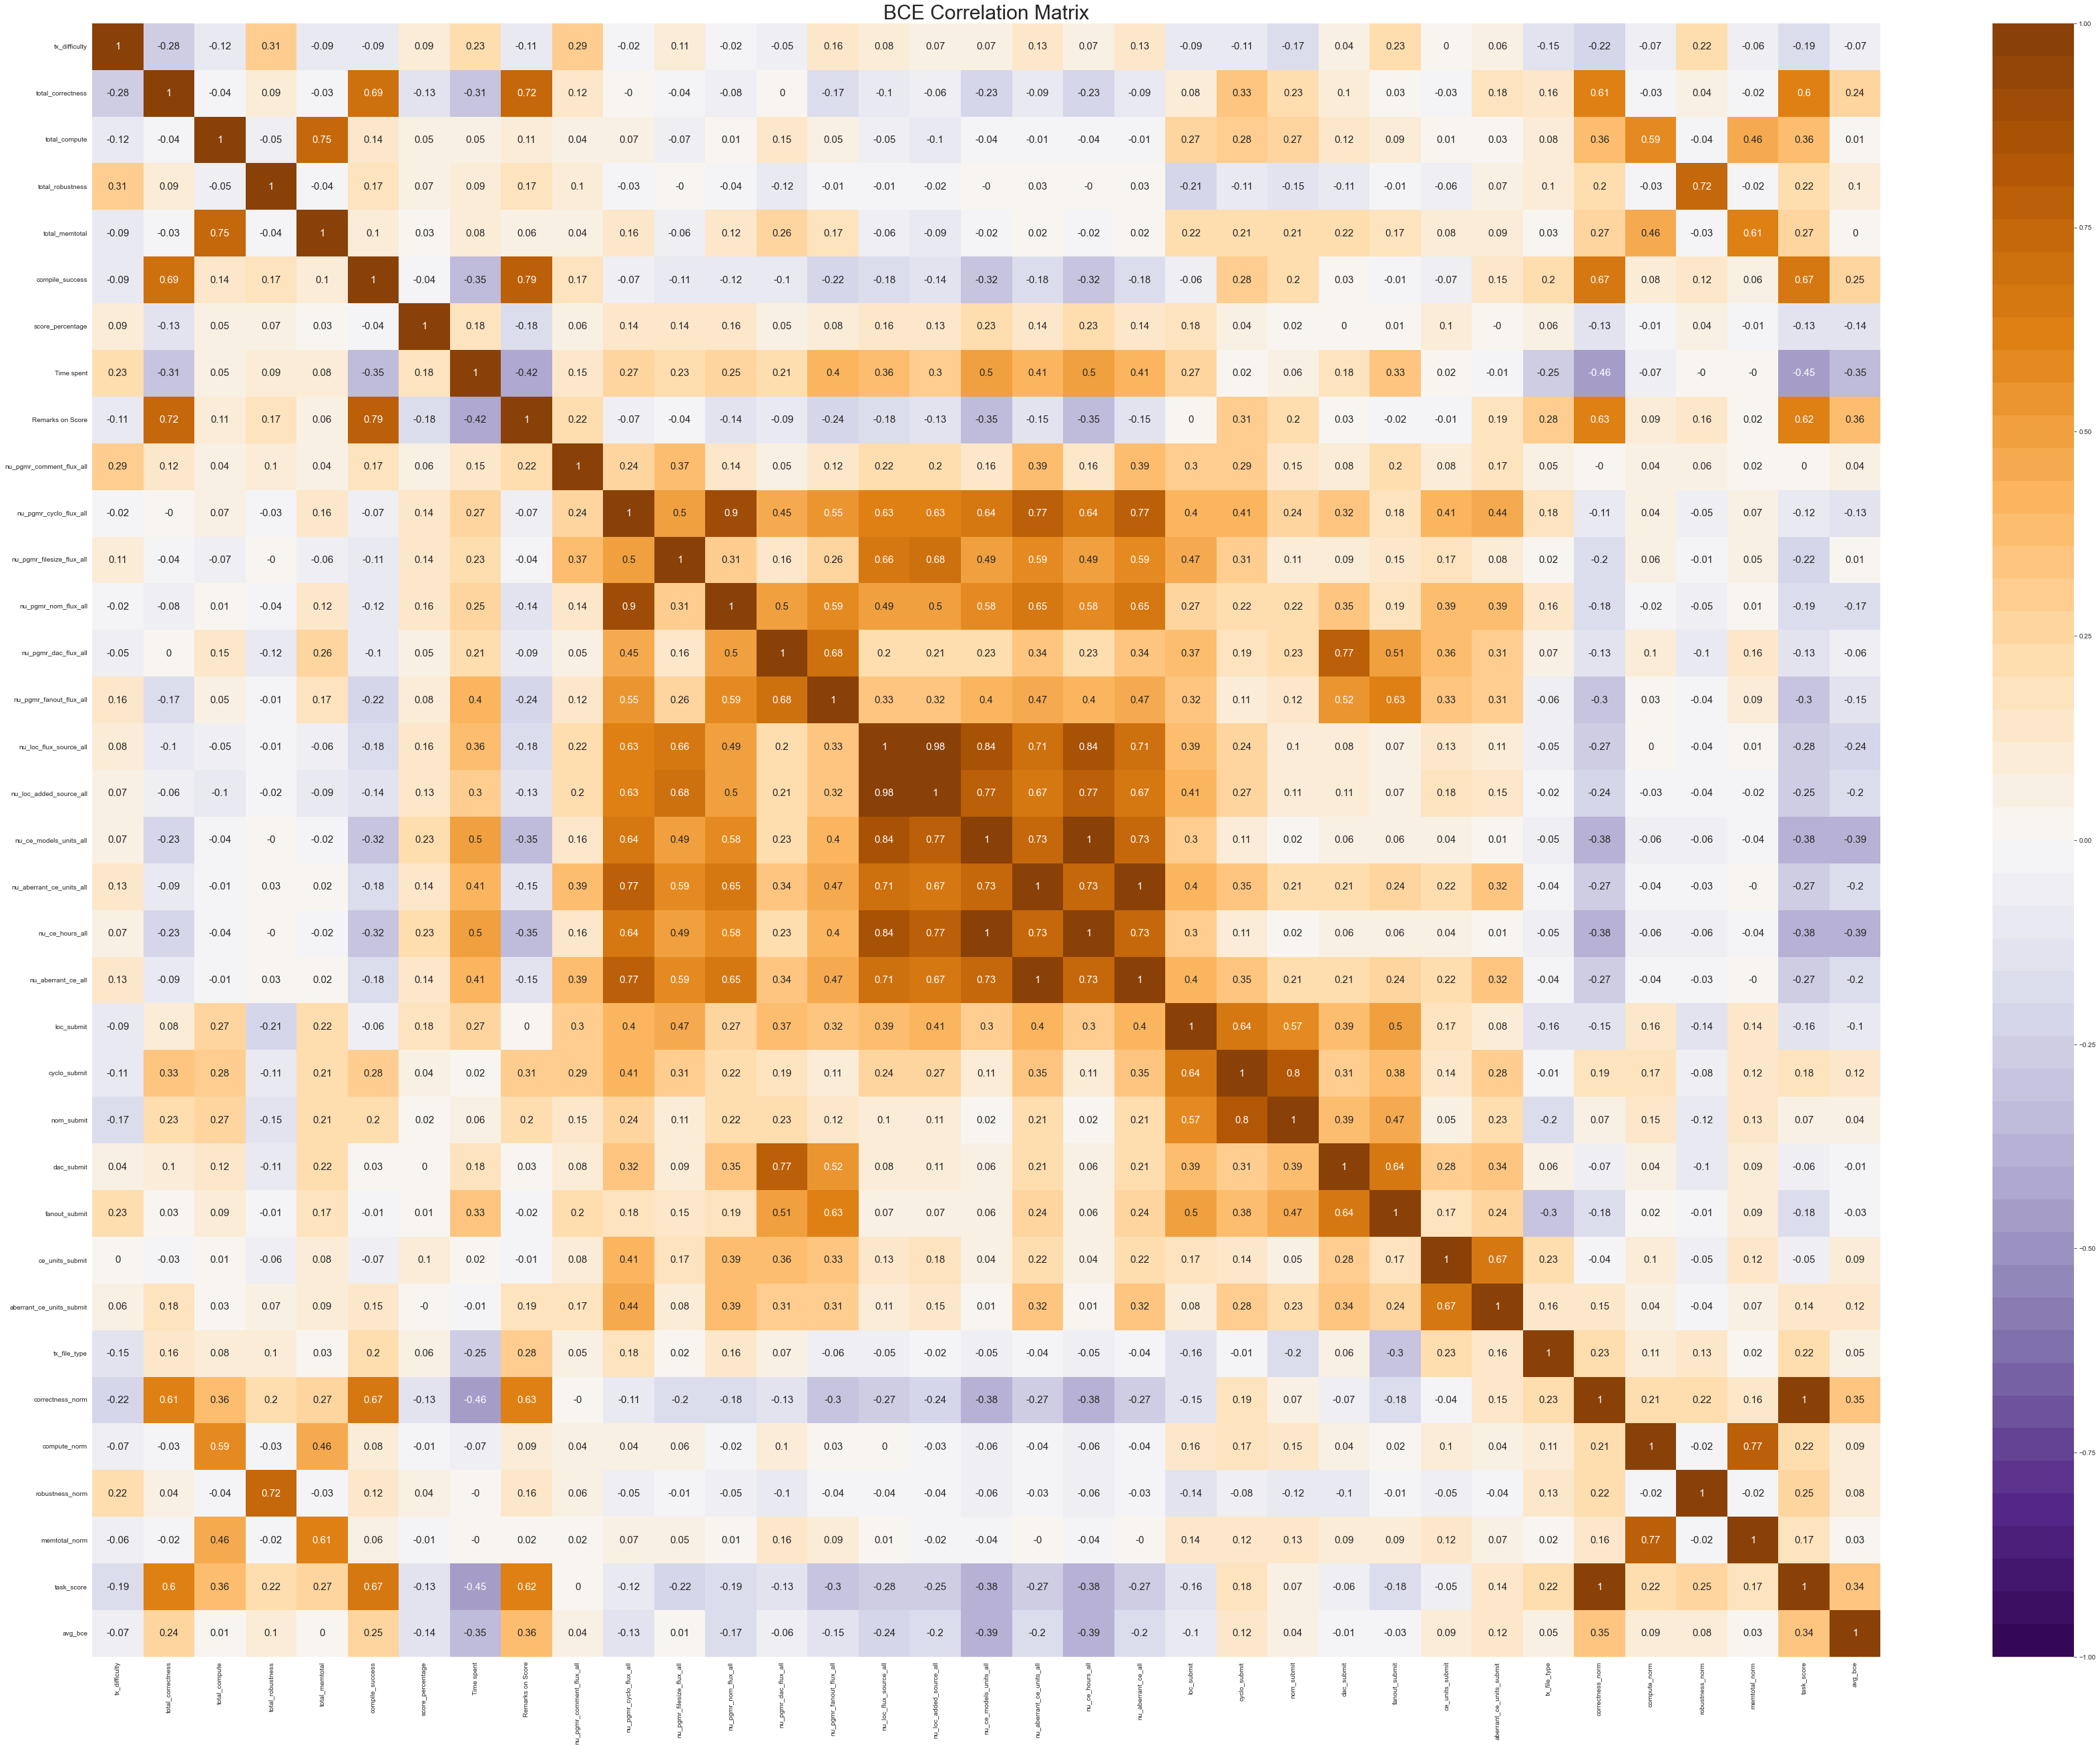

In [11]:
# code to find the coorelation matrix
def coorelation_matrix_plot(data, title = "BCE Correlation Matrix", height = 45, width = 60):
    cor_mat = round(data.corr(method ="spearman"), 2)
    plt.figure(figsize = (width, height))
    ax = sns.heatmap(cor_mat, annot=True, annot_kws={"size": 15}, cmap = sns.color_palette("PuOr_r", 50), 
                     vmin = -1, vmax = 1)
    ax.axes.set_title(title, fontsize = 30)
    ax.title.set_position([.5, 1.03])
    plt.savefig("coorelation_fig.png")
    plt.show()
    
coorelation_matrix_plot(data, title = "BCE Correlation Matrix")

In [12]:
# code to get top coorelations pair from the table above the threshold=0.80
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


print("Top Absolute Correlations")
print(get_top_abs_correlations(data, 20))

Top Absolute Correlations
nu_ce_models_units_all    nu_ce_hours_all             1.000000
nu_aberrant_ce_units_all  nu_aberrant_ce_all          1.000000
nu_loc_flux_source_all    nu_loc_added_source_all     0.992038
correctness_norm          task_score                  0.906456
nu_pgmr_cyclo_flux_all    nu_pgmr_nom_flux_all        0.869965
nu_pgmr_dac_flux_all      nu_pgmr_fanout_flux_all     0.852921
compile_success           Remarks on Score            0.817720
cyclo_submit              nom_submit                  0.796226
total_compute             total_memtotal              0.748853
total_robustness          robustness_norm             0.740970
total_compute             task_score                  0.740385
compute_norm              memtotal_norm               0.727689
dac_submit                fanout_submit               0.716615
compute_norm              task_score                  0.716509
loc_submit                cyclo_submit                0.714435
total_compute             cor

# 2.8 Removing one of the features with high coorelation

In [13]:
# code to remove one of the highly coorelated features so as to reduce dimensionality
def remove_cols_with_high_correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    print("Removing feature ",colname)
                    del dataset[colname] # deleting the column from the dataset

    return dataset

data = remove_cols_with_high_correlation(data,0.8)

Removing feature  Remarks on Score
Removing feature  nu_pgmr_nom_flux_all
Removing feature  nu_pgmr_fanout_flux_all
Removing feature  nu_loc_added_source_all
Removing feature  nu_ce_hours_all
Removing feature  nu_aberrant_ce_all
Removing feature  task_score


In [14]:
#to check if all coorelations have coorelation value less than threshold
print(get_top_abs_correlations(data, 20))

cyclo_submit            nom_submit                  0.796226
total_compute           total_memtotal              0.748853
total_robustness        robustness_norm             0.740970
compute_norm            memtotal_norm               0.727689
dac_submit              fanout_submit               0.716615
loc_submit              cyclo_submit                0.714435
total_compute           correctness_norm            0.701269
nu_ce_models_units_all  nu_aberrant_ce_units_all    0.682939
nu_pgmr_cyclo_flux_all  nu_aberrant_ce_units_all    0.682192
                        nu_pgmr_dac_flux_all        0.658681
ce_units_submit         aberrant_ce_units_submit    0.656015
nu_pgmr_dac_flux_all    dac_submit                  0.654968
nu_loc_flux_source_all  nu_ce_models_units_all      0.632691
loc_submit              nom_submit                  0.616721
nu_pgmr_cyclo_flux_all  nu_ce_models_units_all      0.608335
total_compute           compute_norm                0.589282
nu_loc_flux_source_all  

## 2.9 Most coorelated features with target variable 

Here i find the most coorelated features with target variable i.e above threshold value of 0.2 to get sense of the most prospective important features

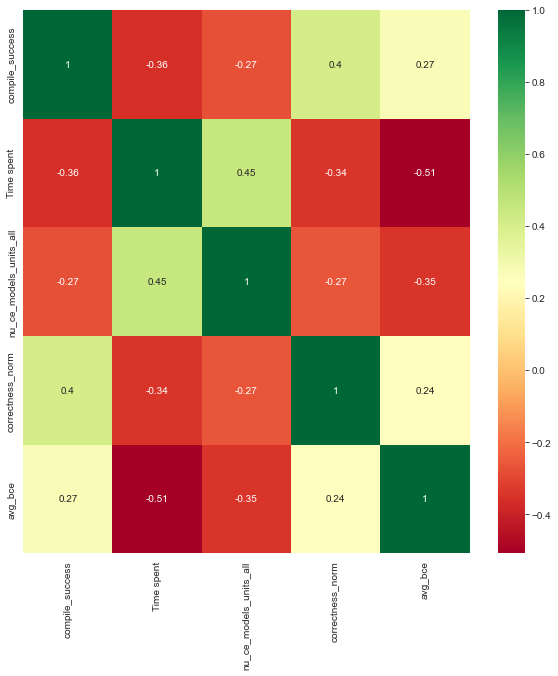

In [15]:
#coorelation matrix of highly coorelation features with target variable
corr = data.corr()
highest_corr_features = corr.index[abs(corr["avg_bce"])>0.2]
plt.figure(figsize=(10,10))
g = sns.heatmap(data[highest_corr_features].corr(),annot=True,cmap="RdYlGn")

In [16]:
# highly coorelated features with target variable sorted in ascending order
corr["avg_bce"].sort_values(ascending=False)

avg_bce                      1.000000
compile_success              0.272554
correctness_norm             0.243443
total_correctness            0.177052
tx_file_type                 0.141161
compute_norm                 0.110004
cyclo_submit                 0.104231
total_robustness             0.103196
nu_pgmr_comment_flux_all     0.099230
ce_units_submit              0.096294
robustness_norm              0.083210
aberrant_ce_units_submit     0.065218
nu_pgmr_filesize_flux_all    0.065140
memtotal_norm                0.062620
nom_submit                   0.035782
total_compute                0.014483
total_memtotal               0.000673
dac_submit                  -0.016405
nu_pgmr_dac_flux_all        -0.065547
tx_difficulty               -0.068541
fanout_submit               -0.070948
loc_submit                  -0.076005
score_percentage            -0.135871
nu_loc_flux_source_all      -0.157179
nu_pgmr_cyclo_flux_all      -0.164373
nu_aberrant_ce_units_all    -0.168638
nu_ce_models

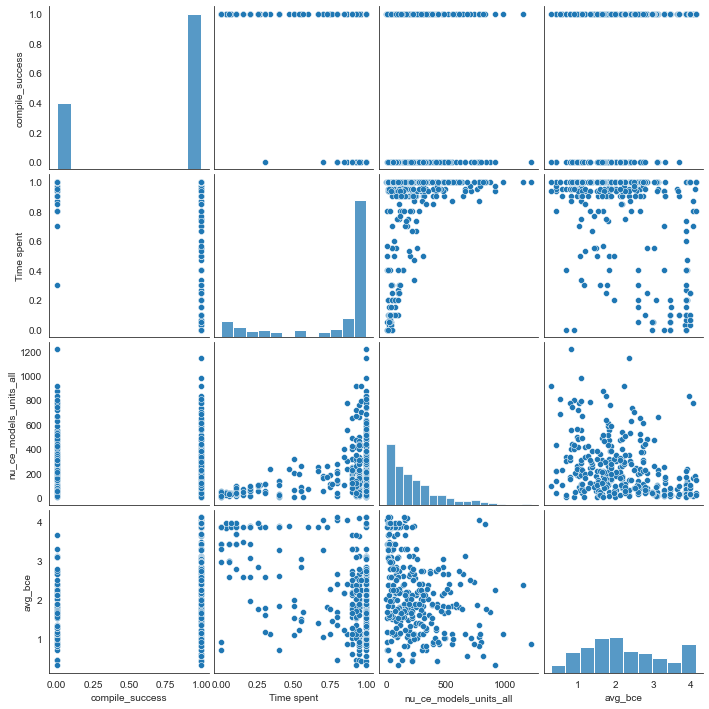

In [17]:
# pair plot of highly coorelated features
cols = ['compile_success','Time spent','nu_ce_models_units_all','avg_bce']
sns.pairplot(data[cols])

## 2.10 Understanding data distribution

It involves checking skewness and kurtosis for independent variable and dependent variables i.e all features in the dataset.

If they show high skewness then it needs to be converted into normal distribution using **Box Cox Transformation**



D:\ML_Projects\myenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_bce', ylabel='Density'>

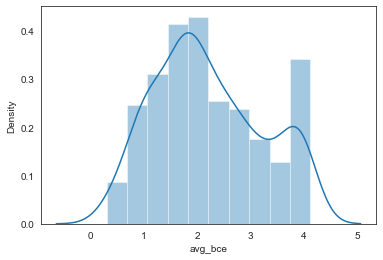

In [18]:
# distribution plot for target variable
sns.distplot(data['avg_bce'])

In [19]:
print("Skewness: %f" % data['avg_bce'].skew())
print("Kurtosis: %f" % data['avg_bce'].kurt())

Skewness: 0.299034
Kurtosis: -0.886569


# A.3 Observations

1. We observe that target variable is not skewed 
2. We now check for the features in the dataset and apply box cox transformation on features with skewness>0.5

In [20]:
numeric_feats = data.dtypes[data.dtypes != 'object'].index
skewed_feats = data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_feats[abs(skewed_feats) > 0.5]
high_skew

memtotal_norm                12.240169
compute_norm                  7.938223
total_memtotal                6.186667
nu_pgmr_comment_flux_all      6.167970
nu_loc_flux_source_all        5.876027
robustness_norm               5.860450
total_compute                 4.540455
nu_pgmr_dac_flux_all          4.399060
total_robustness              3.832890
nu_pgmr_filesize_flux_all     3.568291
aberrant_ce_units_submit      3.367833
nu_aberrant_ce_units_all      3.214079
nu_pgmr_cyclo_flux_all        3.138503
dac_submit                    2.320612
correctness_norm              2.190039
fanout_submit                 1.647653
total_correctness             1.539863
nu_ce_models_units_all        1.505911
cyclo_submit                  1.301276
loc_submit                    1.204641
nom_submit                    1.057397
ce_units_submit               0.881710
tx_file_type                  0.694475
score_percentage             -0.707937
compile_success              -0.872872
Time spent               

In [21]:
numeric_feats = data.dtypes[data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
memtotal_norm,12.240169
compute_norm,7.938223
total_memtotal,6.186667
nu_pgmr_comment_flux_all,6.167970
nu_loc_flux_source_all,5.876027
robustness_norm,5.860450
total_compute,4.540455
nu_pgmr_dac_flux_all,4.399060
total_robustness,3.832890
nu_pgmr_filesize_flux_all,3.568291


In [22]:
skewness = skewness[abs(skewness) > 0.75]

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    data[feat] = boxcox1p(data[feat], lam)
    
print("{} skewed numerical features are transformed using Box Cox transform".format(skewness.shape[0]))


28 skewed numerical features are transformed using Box Cox transform


In [23]:
data.columns

Index(['tx_difficulty', 'total_correctness', 'total_compute',
       'total_robustness', 'total_memtotal', 'compile_success',
       'score_percentage', 'Time spent', 'nu_pgmr_comment_flux_all',
       'nu_pgmr_cyclo_flux_all', 'nu_pgmr_filesize_flux_all',
       'nu_pgmr_dac_flux_all', 'nu_loc_flux_source_all',
       'nu_ce_models_units_all', 'nu_aberrant_ce_units_all', 'loc_submit',
       'cyclo_submit', 'nom_submit', 'dac_submit', 'fanout_submit',
       'ce_units_submit', 'aberrant_ce_units_submit', 'tx_file_type',
       'correctness_norm', 'compute_norm', 'robustness_norm', 'memtotal_norm',
       'avg_bce'],
      dtype='object')

# 3.1 Preparing the data for Training

In [24]:
X,Y = data.iloc[:,:-1],data.iloc[:,-1]
print(X.shape)
print(Y.shape)

(330, 27)
(330,)


In [25]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=42,test_size=0.2)

# 3.2 Model Training 

I use the following models for training

1. Lasso Regression
2. Gradient Boosting
3. XGBoost 
4. Light Gradient Boosting

After training i use the following metrics to compare their results

1. RMSE(Root Mean Squared Error)
2. R^2 score

In [26]:

scorer = make_scorer(mean_squared_error,greater_is_better = False)
def rmse_CV_train(model):
    kf = KFold(5,shuffle=True,random_state=42).get_n_splits(x_train.values)
    rmse = np.sqrt(-cross_val_score(model, x_train, y_train,scoring ="neg_mean_squared_error",cv=kf))
    return (rmse)
def rmse_CV_test(model):
    kf = KFold(5,shuffle=True,random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, x_test, y_test,scoring ="neg_mean_squared_error",cv=kf))

In [27]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train.values)
    rmse= np.sqrt(-cross_val_score(model, x_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


def return_r2_score(model,x_train,y_train,x_test,y_test):
    model.fit(x_train,y_train)
    y_predict = model.predict(x_test)
    y_predict_train = model.predict(x_train)
#     print("Training data r2 score ",r2_score(y_train,y_predict_train))
    print("Testing data r2 score ",r2_score(y_test,y_predict))
    return r2_score(y_test,y_predict)

In [28]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))


GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)


model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)



In [29]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

print("R2 Score ",return_r2_score(lasso,x_train,y_train,x_test,y_test))


Lasso score: 0.3420 (0.0587)

Testing data r2 score  0.24938044266151804
R2 Score  0.24938044266151804


In [30]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

print("R2 Score ",return_r2_score(GBoost,x_train,y_train,x_test,y_test))

Gradient Boosting score: 0.3560 (0.0403)

Testing data r2 score  0.0980752465395196
R2 Score  0.0980752465395196


# 3.3 Hyperparameter Tuning XGBOOST using HyperOpt

We have used HyperOpt over other hyperparameter tuning approaches like RandomSearch and Grid Search because it can be parallelizeable and works faster

In [31]:
from hyperopt import hp
import numpy as np
from sklearn.metrics import mean_squared_error


# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))



In [32]:
import xgboost as xgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials


class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}


In [33]:
obj = HPOpt(x_train, x_test, y_train, y_test)

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)


100%|██████████████████████████████████████████████| 100/100 [00:09<00:00, 10.50trial/s, best loss: 0.2927779125683212]


In [34]:
xgb_opt

({'colsample_bytree': 2,
  'learning_rate': 4,
  'max_depth': 4,
  'min_child_weight': 1,
  'subsample': 0.8880135214414582},
 <hyperopt.base.Trials at 0x2738ac9fbb0>)

In [35]:
# by reusing the best parameters
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=4, 
                             min_child_weight=1, n_estimators=2500,
                             reg_alpha=0.5, reg_lambda=0.8571,
                             subsample=0.5, silent=1,
                             random_state=7, nthread = -1)

In [36]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


print("R2 Score ",return_r2_score(model_xgb,x_train,y_train,x_test,y_test))

[14:50:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:50:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:50:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false

# 3.4 Getting Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

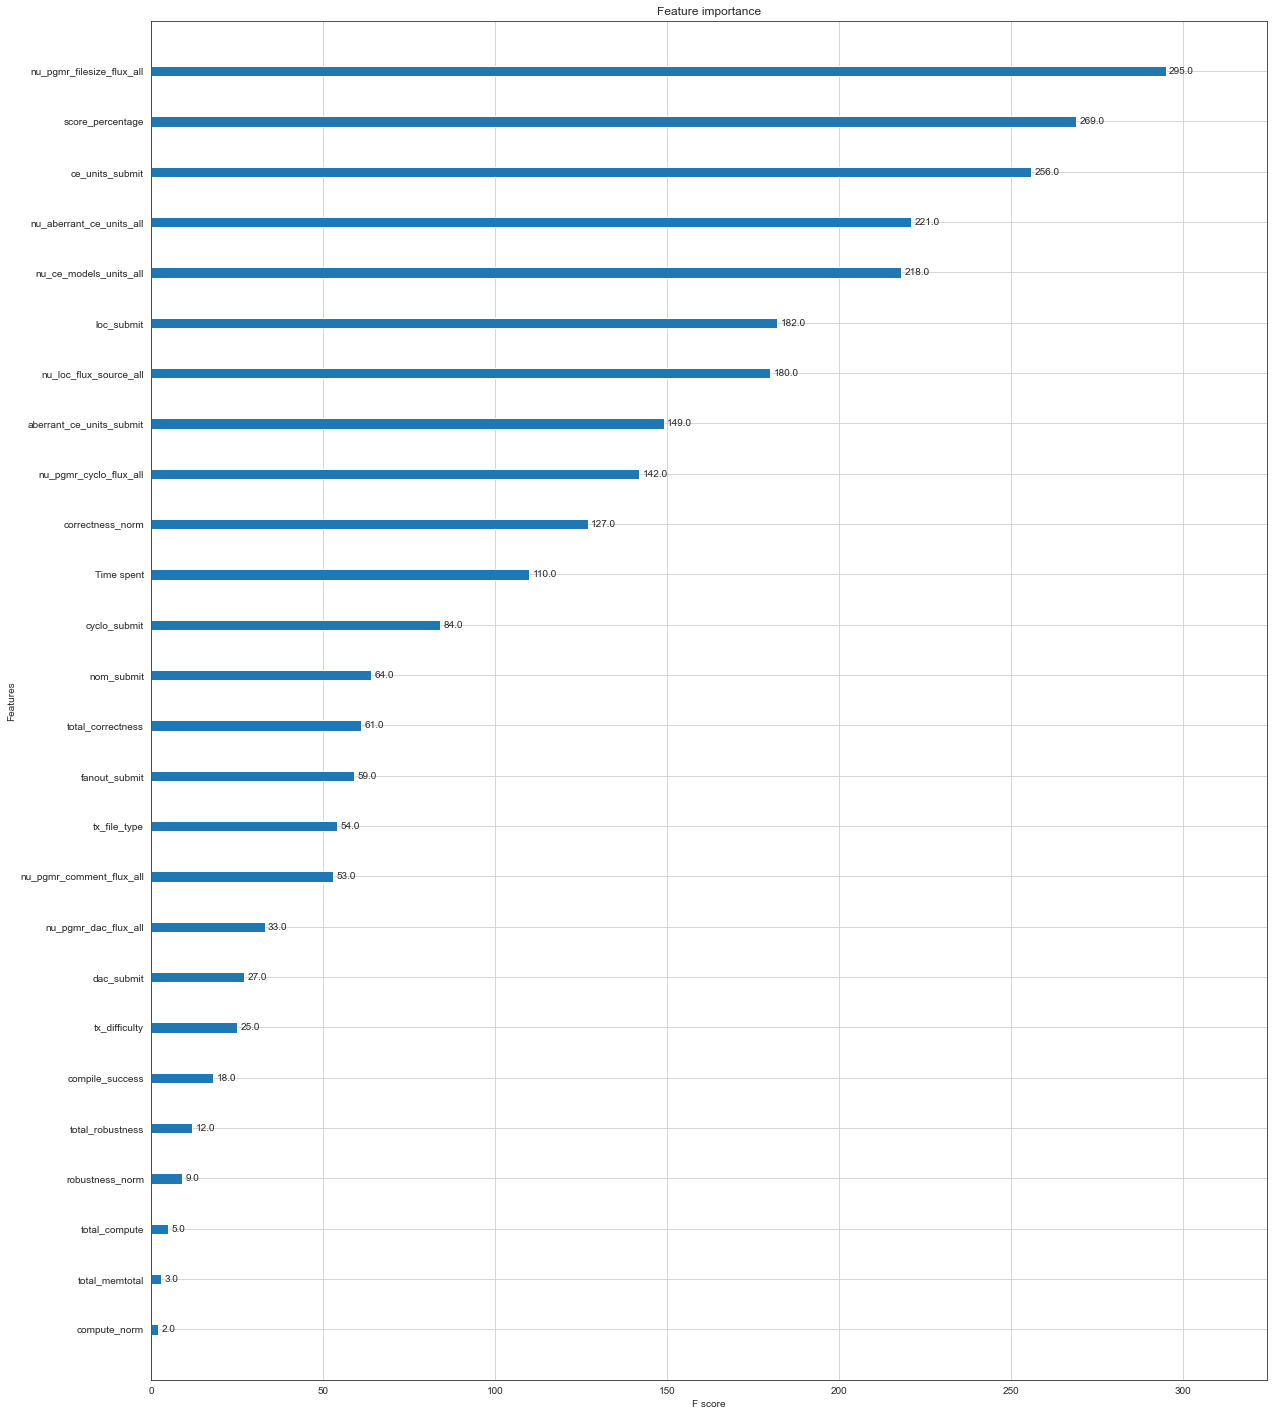

In [37]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(20, 25))
plot_importance(model_xgb, ax=ax)


In [38]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


print("R2 Score ",return_r2_score(model_lgb,x_train,y_train,x_test,y_test))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

# 4.0 Stacking the Models

I also tried stacking the above trained models and average their results so as to reduce the RMSE value even further

In [39]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   
    
averaged_models = AveragingModels(models = (model_xgb,model_lgb, GBoost))

In [40]:
score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[14:50:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Cu

# 5.0 Saving the Pre-requisites for Testing

It involves saving the following things required at testing time

1. trained machine learning model
2. list of features to be used for prediction
3. all pickle files of label encoded to transform the object type variables 

In [41]:
with open('model.pkl', 'wb') as files:
    pickle.dump(model_xgb, files)
    
columns_list = x_train.columns.tolist()
with open('features_list.pkl', 'wb') as files:
    pickle.dump(columns_list, files)

with open('compile_success_lab_en.pkl', 'wb') as files:
    pickle.dump(lab_en2, files)
    
with open('tx_file_type_lab_en.pkl', 'wb') as files:
    pickle.dump(lab_en3, files)
    
with open('tx_difficulty_lab_en.pkl', 'wb') as files:
    pickle.dump(lab_en4, files)

# 6.0 Testing 

## Loading the various prerequisites

In [42]:
with open('model.pkl' , 'rb') as f:
    model_bce = pickle.load(f)
    
with open('compile_success_lab_en.pkl' , 'rb') as f:
    lab_en_compile_success = pickle.load(f)

with open('tx_file_type_lab_en.pkl' , 'rb') as f:
    lab_en_tx_file_type = pickle.load(f)

with open('tx_difficulty_lab_en.pkl' , 'rb') as f:
    lab_en_tx_diff = pickle.load(f)

with open('features_list.pkl' , 'rb') as f:
    features_list = pickle.load(f)

In [43]:
data = pd.read_csv("pa_work_sample_training_data.csv")

In [44]:
row = data.iloc[0,:]

In [45]:
row

tx_name                                                                      0
Task Name                                                                   15
tx_difficulty                                                     intermediate
total_correctness                                                            0
total_compute                                                                0
total_robustness                                                             0
total_memtotal                                                               0
made_submission                                                           True
compile_success                                                           True
score_percentage                                                          70.7
Time spent                                                                0.95
Remarks on Score                                                        FAILED
id_task_session                                     

In [46]:
#code to transform all the variables
row['tx_difficulty'] = lab_en_tx_diff.transform([row['tx_difficulty']])[0]
row['compile_success'] = lab_en_compile_success.transform([row['compile_success']])[0]
row['tx_file_type'] = lab_en_tx_file_type.transform([row['tx_file_type']])[0]

D:\ML_Projects\myenv\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


In [47]:
row

tx_name                                                                      0
Task Name                                                                   15
tx_difficulty                                                                2
total_correctness                                                            0
total_compute                                                                0
total_robustness                                                             0
total_memtotal                                                               0
made_submission                                                           True
compile_success                                                              1
score_percentage                                                          70.7
Time spent                                                                0.95
Remarks on Score                                                        FAILED
id_task_session                                     

# 6.1 Predicting on a random row

In [48]:
#code to select the relevant features used while testing 
x_test = dict()
for feature in features_list:
    x_test[feature] = row[feature]
print(x_test)

x_test = pd.DataFrame([x_test])
print("Shape of the file expected by model ",x_train.shape)
print("Shape of the modified x test ",x_test.shape)

{'tx_difficulty': 2, 'total_correctness': 0, 'total_compute': 0, 'total_robustness': 0, 'total_memtotal': 0, 'compile_success': 1, 'score_percentage': 70.7, 'Time spent': 0.95, 'nu_pgmr_comment_flux_all': 0, 'nu_pgmr_cyclo_flux_all': 10, 'nu_pgmr_filesize_flux_all': 1622, 'nu_pgmr_dac_flux_all': 2, 'nu_loc_flux_source_all': 55, 'nu_ce_models_units_all': 70.67056659086927, 'nu_aberrant_ce_units_all': 3.3603286788694304, 'loc_submit': 42, 'cyclo_submit': 8, 'nom_submit': 6, 'dac_submit': 2, 'fanout_submit': 2, 'ce_units_submit': 6.541836768847178, 'aberrant_ce_units_submit': 0.0296702964500191, 'tx_file_type': 2, 'correctness_norm': 0.0, 'compute_norm': 0, 'robustness_norm': 0.0, 'memtotal_norm': 0}
Shape of the file expected by model  (264, 27)
Shape of the modified x test  (1, 27)


In [49]:
# predicting on the values selected
pred_bce = model_bce.predict(x_test)
print(pred_bce[0])

0.6574965


# 7.0 Model Interpretability using LIME

In [50]:
import lime
from lime import lime_tabular

interpretor = lime_tabular.LimeTabularExplainer(
    training_data=np.array(x_train),
    feature_names=x_train.columns,
    mode='regression'
)

In [51]:
x_test

,tx_difficulty,total_correctness,total_compute,total_robustness,total_memtotal,compile_success,score_percentage,Time spent,nu_pgmr_comment_flux_all,nu_pgmr_cyclo_flux_all,...,nom_submit,dac_submit,fanout_submit,ce_units_submit,aberrant_ce_units_submit,tx_file_type,correctness_norm,compute_norm,robustness_norm,memtotal_norm
0,2,0,0,0,0,1,70.7,0.95,0,10,...,6,2,2,6.541837,0.02967,2,0.0,0,0.0,0


In [52]:
x_test.iloc[:,:-1].values

array([[2.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 7.07000000e+01, 9.50000000e-01,
        0.00000000e+00, 1.00000000e+01, 1.62200000e+03, 2.00000000e+00,
        5.50000000e+01, 7.06705666e+01, 3.36032868e+00, 4.20000000e+01,
        8.00000000e+00, 6.00000000e+00, 2.00000000e+00, 2.00000000e+00,
        6.54183677e+00, 2.96702965e-02, 2.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]])

In [53]:
exp = interpretor.explain_instance(
    data_row=x_test.iloc[0,:], 
    predict_fn=model_xgb.predict
)

exp.show_in_notebook(show_table=True)